In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
"""
Testing environment with stable_baselines3 library
"""
import sys
sys.path.append('../')

from stable_baselines3.common.env_checker import check_env
from envs.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

env = BatteryStorageInGridEnv()

check_env(env)

/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


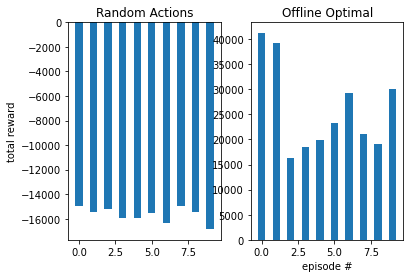

In [4]:
"""
Testing RL agent which randomly chooses actions
"""
import sys
sys.path.append('../')
from typing import List
import numpy as np
import os
import pandas as pd
import gym

from tqdm import tqdm
import matplotlib.pyplot as plt

env = BatteryStorageInGridEnv(date='2019-05')

episodes = 10

rewards_lst_1 = []
off_line_rewards_lst_1 = []

for i in tqdm(range(episodes)):
    ob = env.reset(seed=i)
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)

    while not done:
        # random action as policy
        action = env.action_space.sample()
        # print("step: ", env.count)
        # print("charging costs: ", env.bats_charge_costs)
        # print("discharging costs: ", env.bats_discharge_costs)
        # print("env load: ", env.load_demand)
        state, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    # print("episode {} mean reward: {}".format(i, np.mean(rewards)))
    rewards_lst_1.append(np.sum(rewards))
    ob = env.reset(seed=i)
    off_line_rewards_lst_1.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_1, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_1, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


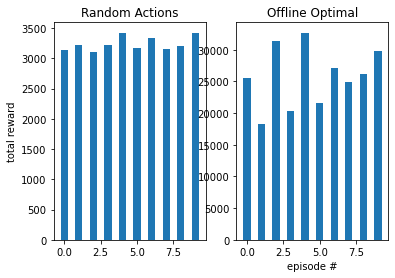

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# env = BatteryStorageInGridEnv(date='2019-05')

# stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
# eval_callback = EvalCallback(env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=1)

# model = PPO("MultiInputPolicy", env, verbose=1)
# model.learn(int(1e10), callback=eval_callback)
# model.save("ppo_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = PPO.load("ppo_single_agent_battery_env")

episodes = 10

rewards_lst_4 = []
off_line_rewards_lst_4 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i)
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_4.append(np.sum(rewards))
    ob = env.reset(seed=i)
    off_line_rewards_lst_4.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_4, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_4, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

In [7]:
from stable_baselines3.ddpg.policies import MultiInputPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG
import numpy as np

env = BatteryStorageInGridEnv(date='2019-05')

stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=1)

# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# model = DDPG(MultiInputPolicy, env, action_noise=action_noise, verbose=1)
model = DDPG("MultiInputPolicy", env, action_noise=action_noise, verbose=1)
model.learn(int(1e10), callback=eval_callback)
model.save("ddpg_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_single_agent_battery_env")

episodes = 10

rewards_lst_2 = []
off_line_rewards_lst_2 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i)
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_2.append(np.sum(rewards))
    ob = env.reset(seed=i)
    off_line_rewards_lst_2.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_2, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_2, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 287      |
|    ep_rew_mean        | 2.49e+03 |
| time/                 |          |
|    fps                | 209      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | -24.7    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0143  |
|    std                | 1        |
|    value_loss         | 3.07e-05 |
------------------------------------


/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=2409.92 +/- 74.85
Episode length: 287.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 287      |
|    mean_reward        | 2.41e+03 |
| time/                 |          |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.83    |
|    explained_variance | -1.13    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.0393   |
|    std                | 0.997    |
|    value_loss         | 0.000208 |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 287      |
|    ep_rew_mean     | 2.5e+03  |
| time/              |          |
|    fps             | 102      |
|    iterations      | 200      |
|    time_elapsed    | 9        |
|    total_timesteps | 1000     |
---------------------------

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


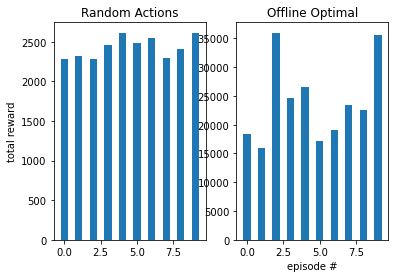

In [8]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

env = BatteryStorageInGridEnv(date='2019-05')

stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=1)

model = A2C("MultiInputPolicy", env, verbose=1)
model.learn(int(1e10), callback=eval_callback)
model.save("a2c_single_agent_battery_env")

del model # remove to demonstrate saving and loading

model = PPO.load("a2c_single_agent_battery_env")

episodes = 10

rewards_lst_3 = []
off_line_rewards_lst_3 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i)
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_3.append(np.sum(rewards))
    ob = env.reset(seed=i)
    off_line_rewards_lst_3.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_3, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_3, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

In [12]:
# Get rewards for Testing on May 2021

model_ppo = PPO.load("ppo_single_agent_battery_env")
model_a2c = PPO.load("a2c_single_agent_battery_env")

episodes = 10

rewards_lst_ppo_21_5 = []
rewards_lst_a2c_21_5 = []
off_line_rewards_lst_21_5 = []

env1 = BatteryStorageInGridEnv(date='2021-05')
env2 = BatteryStorageInGridEnv(date='2021-05')

for i in tqdm(range(episodes)):
    obs = env1.reset(seed=i)
    done = False
    rewards = np.zeros(env1.MAX_STEPS_PER_EPISODE)
    while not done:
        action, _states = model_ppo.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env1.step(action)
        rewards[env1.count - 1] = reward
    
    obs2 = env2.reset(seed=i)
    done2 = False
    rewards2 = np.zeros(env2.MAX_STEPS_PER_EPISODE)
    while not done2:
        action, _states = model_a2c.predict(obs2)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs2, reward, done2, info = env2.step(action)
        rewards2[env2.count - 1] = reward
    rewards_lst_ppo_21_5.append(np.sum(rewards))
    rewards_lst_a2c_21_5.append(np.sum(rewards2))
    ob = env1.reset(seed=i)
    off_line_rewards_lst_21_5.append(env1._calculate_off_optimal_total_episode_reward())

print("2021/5 PPO: ", rewards_lst_ppo_21_5)
print("2021/5 A2C: ", rewards_lst_a2c_21_5)
print("2021/5 Offline Optimal: ", off_line_rewards_lst_21_5)

 30%|███       | 3/10 [00:08<00:19,  2.72s/it]


ValueError: Expected parameter loc (Tensor of shape (1, 2)) of distribution Normal(loc: torch.Size([1, 2]), scale: torch.Size([1, 2])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan]], device='cuda:0')

In [23]:
import numpy as np
from stable_baselines3 import PPO
from tqdm import tqdm

# generate evaluation for PPO trained on May 2019 and tested on May 2019 (in-dist)

env = BatteryStorageInGridEnv(date='2019-05', seed=195)

model_ppo = PPO.load("ppo_single_agent_battery_env")

episodes = 10

rewards_ppo_19_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    while not done:
        action, _states = model_ppo.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_ppo_19_5.append(np.sum(rewards))

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [24]:
import numpy as np
from stable_baselines3 import A2C
from tqdm import tqdm

# generate evaluation for A2C trained on May 2019 and tested on May 2019 (in-dist)

env = BatteryStorageInGridEnv(date='2019-05', seed=195)

model_a2c = A2C.load("a2c_single_agent_battery_env")

episodes = 10

rewards_a2c_19_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    while not done:
        action, _states = model_a2c.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_a2c_19_5.append(np.sum(rewards))

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [25]:
import numpy as np
from stable_baselines3 import A2C
from tqdm import tqdm

# generate off-line optimal values for May 2019

env = BatteryStorageInGridEnv(date='2019-05', seed=195)

offline_optimal_19_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    offline_optimal_19_5.append(env._calculate_off_optimal_total_episode_reward())

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


In [19]:
import numpy as np
from stable_baselines3 import PPO
from tqdm import tqdm

# generate evaluation for PPO trained on May 2019 and tested on May 2021 (out-dist)

env = BatteryStorageInGridEnv(date='2021-05', seed=215)

model_ppo_out = PPO.load("ppo_single_agent_battery_env")

episodes = 10

rewards_ppo_21_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    while not done:
        action, _states = model_ppo_out.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_ppo_21_5.append(np.sum(rewards))

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [20]:
import numpy as np
from stable_baselines3 import A2C
from tqdm import tqdm

# generate evaluation for A2C trained on May 2019 and tested on May 2021 (out-dist)

env = BatteryStorageInGridEnv(date='2021-05', seed=215)

model_a2c_out = A2C.load("a2c_single_agent_battery_env")

episodes = 10

rewards_a2c_21_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    while not done:
        action, _states = model_a2c_out.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_a2c_21_5.append(np.sum(rewards))

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


In [12]:
import numpy as np
from stable_baselines3 import A2C
from tqdm import tqdm

# generate off-line optimal values for May 2019

env = BatteryStorageInGridEnv(date='2021-05', seed=215)

offline_optimal_21_5 = []

for i in tqdm(range(episodes)):
    obs = env.reset(seed=i*10)
    offline_optimal_21_5.append(env._calculate_off_optimal_total_episode_reward())

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


2019/5 PPO:  [2245.0145741723068, 2558.4557707267295, 2536.6470375887716, 2213.9489259221714, 2545.763597560765, 2602.458985199197, 2372.820422435832, 2548.4725186985274, 2261.2602848462757, 2779.4824376099523]
2019/5 A2C:  [2245.0145743153016, 2558.4557716921063, 2536.647038219378, 2213.948927097822, 2545.763598501142, 2602.458988265422, 2372.82042346052, 2548.472526844007, 2261.2602856102226, 2779.4824385186284]
2019/5 Offline Optimal:  [23051.710297436803, 18248.597237755643, 18994.697055206787, 22868.55334810844, 16514.00674815259, 33131.47019110864, 14612.253560855821, 22389.303426021896, 23079.613407532303, 23031.783863923756]
2021/5 PPO:  [2743.0189450456783, 2609.6690354598877, 2641.4290383788198, 2714.706752567427, 2342.052034742505, 2732.207455008233, 2753.6307763219734, 2784.0557684839923, 2722.8755581028713, 2835.9102791492815]
2021/5 A2C:  [2743.0189478052616, 2609.6690381383055, 2641.42903982744, 2714.7067542683335, 2342.0520677395284, 2732.207453737356, 2753.630777941933

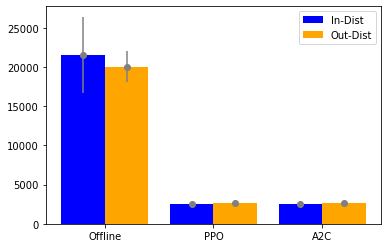

In [26]:
import numpy as np
import matplotlib.pyplot as plt

print("2019/5 PPO: ", rewards_ppo_19_5)
print("2019/5 A2C: ", rewards_a2c_19_5)
print("2019/5 Offline Optimal: ", offline_optimal_19_5)
print("2021/5 PPO: ", rewards_ppo_21_5)
print("2021/5 A2C: ", rewards_a2c_21_5)
print("2021/5 Offline Optimal: ", offline_optimal_21_5)

models = ['Offline', 'PPO', 'A2C']
in_dist = [np.mean(offline_optimal_19_5), np.mean(rewards_ppo_19_5), np.mean(rewards_a2c_19_5)]
out_dist = [np.mean(offline_optimal_21_5), np.mean(rewards_ppo_21_5), np.mean(rewards_a2c_21_5)]

x_axis = np.arange(len(models))

plt.bar(x_axis - 0.2, in_dist, width=0.4, label='In-Dist', color='blue')
plt.bar(x_axis + 0.2, out_dist, width=0.4, label='Out-Dist', color='orange')

in_dist_err = [np.std(offline_optimal_19_5), np.std(rewards_ppo_19_5), np.std(rewards_a2c_19_5)]
out_dist_err = [np.std(offline_optimal_21_5), np.std(rewards_ppo_21_5), np.std(rewards_a2c_21_5)]

plt.errorbar(x_axis - 0.2, in_dist, yerr=in_dist_err, fmt='o', color='gray')
plt.errorbar(x_axis + 0.2, out_dist, yerr=out_dist_err, fmt='o', color='gray')

plt.xticks(x_axis, models)
plt.legend()
plt.show()